# Analysis of Annif suggestions in Theseus repository    

## Install and import packages
In VS Code the simplest way to install packages in correct venv is to do it in the notebook.

In [1]:
! pip install --upgrade pip setuptools wheel
! pip install ndjson pandas rdflib matplotlib jinja2

import ndjson
import pandas as pd
from rdflib import Graph, Literal, Namespace
from rdflib.namespace import OWL, SKOS
import unicodedata
import matplotlib.pyplot as plt
import matplotlib
import datetime

In [2]:
# load current YSA
ysa = Graph()
ysa.parse('http://finto.fi/rest/v1/ysa/data?format=text/turtle')
print('Number of triples in YSA: ', len(ysa))

# load current Allärs
allars = Graph()
allars.parse('http://finto.fi/rest/v1/allars/data?format=text/turtle')
print('Number of triples in Allärs: ', len(allars))


Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x7f93db50ad30>
Traceback (most recent call last):
  File "/home/local/jmminkin/git/FintoAI-data-YSO/repository-metrics-analysis/.venv/lib/python3.8/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
  File "/home/local/jmminkin/git/FintoAI-data-YSO/repository-metrics-analysis/.venv/lib/python3.8/site-packages/isodate/isodates.py", line 201, in parse_date
    return date(sign * int(groups['year']),
ValueError: month must be in 1..12


Number of triples in YSA:  433048
Number of triples in Allärs:  412097


In [3]:
# load YSO and YSO Places
yso = Graph()
yso.parse("../Annif-corpora/vocab/yso-skos.ttl", format='turtle')
print('Number of triples in YSO+YSO Places: ', len(yso))

Number of triples in YSO+YSO Places:  830887


# Helper functions

In [53]:
YSO = Namespace('http://www.yso.fi/onto/yso/')
COMPLAIN = False  # whether to complain about unknown labels


def is_deprecated(ysouri):
    return (ysouri, OWL.deprecated, True) in yso


def label_to_yso_uris(label, voc, lang, complain=COMPLAIN):
    # based on https://github.com/NatLibFi/Annif-corpora/blob/6521d0357f3d93019f6d2838b960e80d9131735c/tools/finna-metadata-collect-scripts/create-corpus.py#L54
    
    # Remove trailing "." present in labels of some records
    try:
        value = Literal(unicodedata.normalize('NFC', label.rstrip('.')), lang)
    except Exception as e:
        print("Error normalizing label '{}'".format(label))
        return []

    for prop in (SKOS.prefLabel, SKOS.altLabel):
        vocuri = voc.value(None, prop, value, any=True)
        if vocuri is not None:
            if vocuri.startswith(YSO):
                return [vocuri]
            for matchprop in (SKOS.exactMatch, SKOS.closeMatch):
                matches = [match for match in voc.objects(vocuri, matchprop)
                           if match.startswith(YSO)]
                if matches:
                    return matches

    # hackish fallbacks for cases like "kulttuuri", where YSO Cicero is out of
    # date: look up via ysa/allars
    if lang == 'fi' and voc == yso:
        matches = label_to_yso_uris(label, ysa, lang)
        if matches:
            #print("missing fi label '{}' found via ysa".format(label))
            return matches

    if lang == 'sv' and voc == yso:
        matches = label_to_yso_uris(label, allars, lang)
        if matches:
            #print("missing sv label '{}' found via allars".format(label))
            return matches

    if complain:
        print("Unknown label '{}'".format(label))
    return []


def add_subjects_uris(df, lang, source_col):
    df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
    df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])
    return df


def calc_scores(df):
    # calculate precision, recall, f1
    df["precision"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.suggestions) if len(x.suggestions) > 0 else pd.np.nan, axis=1)
    df["recall"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.subjects_uris) if len(x.subjects_uris) > 0 else pd.np.nan, axis=1)
    df["f1 score"] = df.apply(lambda x: 2 * x.precision * x.recall / (x.precision + x.recall) if (x.precision + x.recall) != 0 else 0, axis=1)
    df['f1 score'] = pd.to_numeric(df['f1 score'])


def plot_scores(df):
    calc_scores(df)

    # mark annif_updates in the plot
    for upd in annif_updates:
        plt.axvline(upd, color='red', linestyle='--')

    # plot precision, recall, f1 as a function of time. Label with month start
    df_monthly = df.set_index("date_accessioned").resample('MS').mean()
    df_monthly.plot(marker='o', ax=plt.gca())
    # labels = [x.strftime("%Y-%m") for x in df_monthly.index]
    # plt.gca().set_xticklabels(labels, rotation=45)
    # plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.grid()


def plot_counts(df):
    # How many records there are with suggestions each month? Label with month start
    df_monthly = df.set_index('date_accessioned').resample("MS").id.count()
    # df_monthly.plot.bar()
    plt.bar(df_monthly.index, df_monthly, width=20)
    # plt.ylabel("Number of records")
    plt.grid()


def get_number_of_rows(df):
    print("rows: ", len(df))
    print("rows with subjects_yso: ", len(df[df.subjects_yso.apply(lambda x: len(x) > 0)]))
    print("rows with subjects_all: ", len(df[df.subjects_all.apply(lambda x: len(x) > 0)]))
    print("rows with suggestions: ", len(df[df.suggestions.apply(lambda x: len(x) > 0)]))
    print("rows with subjects_uris: ", len(df[df.subjects_uris.apply(lambda x: len(x) > 0)]))
    print("rows with both suggestions & subject_uris: ", len(retain_relevant(df)))


def retain_relevant(df):
    df = df.copy()
    return df[df.suggestions.apply(lambda x: len([e for e in x if e != '']) > 0) & df.subjects_uris.apply(lambda x: len([e for e in x if e != '']) > 0)]


# Dates when Annif models were updated in Finto AI
annif_updates = [
    # "2020-03-26",
    "2020-12-09",
    "2021-04-27",
    "2021-11-11",
    "2022-06-21",
    "2022-11-22",
]
# convert to datetime with utc timezone
annif_updates = [datetime.datetime.strptime(x, "%Y-%m-%d").replace(tzinfo=datetime.timezone.utc) for x in annif_updates]

def get_annif_update(date):
    return max([upd for upd in annif_updates if upd<date], default=None)


## Load data

In [5]:
with open("theseus.ndjson") as f:
    data = ndjson.load(f)
df = pd.DataFrame(data)

df.date_issued = pd.to_datetime(df.date_issued, errors='coerce', utc=True)
df.date_accessioned = pd.to_datetime(df.date_accessioned, errors='coerce', utc=True)
df['annif_update'] = df.date_accessioned.map(get_annif_update)
df.rename(columns={'lang': 'language'}, inplace=True)


print(len(df))
df_fi = df[(df.language == 'fin') | (df.language == 'fi')]
print(len(df_fi))
df_en = df[(df.language == 'eng') | (df.language == 'en')]
print(len(df_en))
df_sv = df[(df.language == 'swe') | (df.language == 'sv')]
print(len(df_sv))

57488
47296
8102
1884


In [6]:
df_fi = add_subjects_uris(df_fi, 'fi', source_col='subjects_all')
get_number_of_rows(df_fi)
# Retain only rows having both suggestions and subjects_uris
df_fi = retain_relevant(df_fi)
print()
title_str = "Theseus suomi"
df_fi.type.value_counts()

Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'


/tmp/ipykernel_311370/1465619038.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
/tmp/ipykernel_311370/1465619038.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])


rows:  47296
rows with subjects_yso:  45512
rows with subjects_all:  46718
rows with suggestions:  47296
rows with subjects_uris:  46498
rows with both suggestions & subject_uris:  43192



fi=AMK-opinnäytetyö|sv=YH-examensarbete|en=Bachelor's thesis|                                                                    35269
fi=Ylempi AMK-opinnäytetyö|sv=Högre YH-examensarbete|en=Master's thesis|                                                          6998
publication                                                                                                                        837
fi=Publisher's version|sv=Publisher's version|en=Publisher's version|                                                               50
fi=Erikoistumisopintojen opinnäytetyö|sv=Examensarbete för specialiseringsutbildning|en=Thesis for specialisation studies|          36
fi=Opettaja-AMK-opinnäytetyö|sv=Examensarbete för yrkeslärarutbildning|en=Bachelor's thesis for vocational teacher education|        2
Name: type, dtype: int64

## Main results: precision, recall, and f1 over time

/tmp/ipykernel_311370/793406199.py:71: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.set_index("date_accessioned").resample('MS').mean()
/tmp/ipykernel_311370/3260459212.py:6: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f93644e3370> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "_", "_", "_", "_", "tarkkuus", "saanti", "F1-arvo"]) #, loc='center right')
/tmp/ipykernel_311370/3260459212.py:6: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f93644ec370> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "_", "_", "_", "_", "tarkkuus", "saanti", "F1-arvo"]) #, loc='center right')
/tmp/ipykernel_311370/3260459212.py:6: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7f93644e

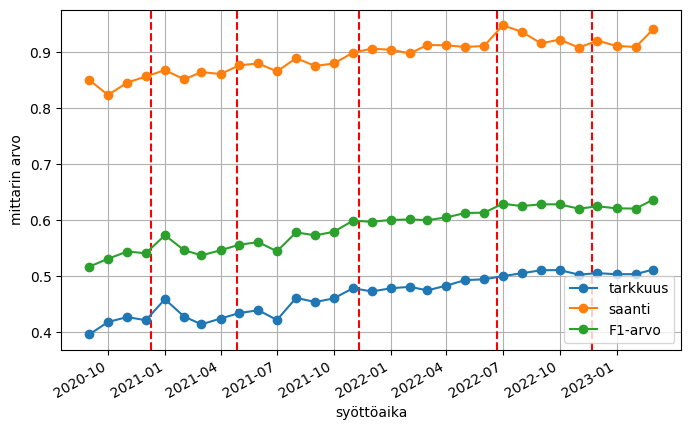

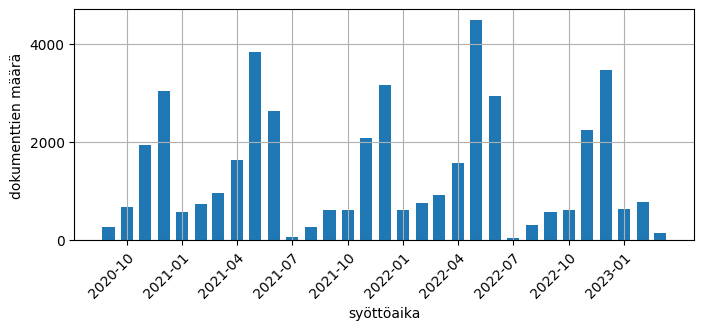

In [54]:
plt.figure(figsize=(8, 5))
plot_scores(df_fi)
plt.xlabel("syöttöaika")
plt.ylabel("mittarin arvo")
# hide legend labels of vertical lines and change other labels to finnish
plt.legend(["_", "_", "_", "_", "_", "tarkkuus", "saanti", "F1-arvo"]) #, loc='center right')
# set x ticks to every 3 months starting from 2020-10, ticks to start of month
plt.gca().set_xticks(pd.date_range("2020-10-01", "2023-03-31", freq="3MS"))
# format x ticks to month-year
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))


plt.figure(figsize=(8, 3))
plot_counts(df_fi)
plt.xlabel("syöttöaika")
plt.ylabel("dokumenttien määrä")
plt.yticks([0, 2000, 4000, ])
# set x ticks to every 3 months starting from 2020-10, ticks to start of month
plt.gca().set_xticks(pd.date_range("2020-10-01", "2023-03-31", freq="3MS"))
# format x ticks to month-year
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
# rotate x tick labels
_ = plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

In [55]:
# Group by annif_update and give mean precision, recall, f1
df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).style.set_caption(title_str)

/tmp/ipykernel_311370/3516352905.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).style.set_caption(title_str)


## Distributions

Text(0.5, 0, 'mittarin arvo')

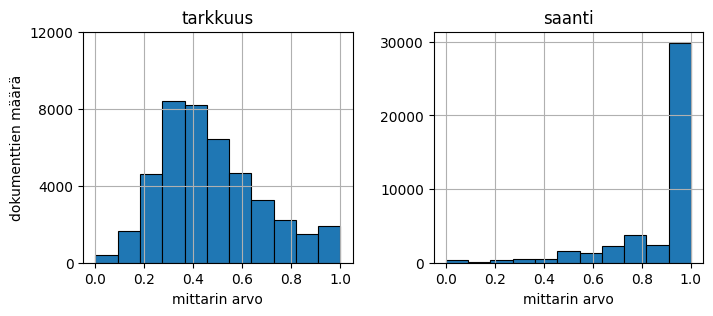

In [100]:
 # 11 bins to avoid empty bins (due to bin open interval on right edges?)
df_fi[['precision', 'recall']].hist(bins=11, figsize=(8, 3), edgecolor = "black", linewidth = 0.8)
plt.gca().set_title("saanti")
# plt.ylabel("dokumenttien määrä")
plt.xlabel("mittarin arvo")
plt.yticks([0, 10000, 20000, 30000])

# select axis of first subplot
plt.sca(plt.gcf().axes[0])
plt.yticks([0, 4000, 8000, 12000])
plt.gca().set_title("tarkkuus")
plt.ylabel("dokumenttien määrä")
plt.xlabel("mittarin arvo")


The histogram of recall above indicates that nearly never users assigns subjects that
are not suggested by Annif. 

,subjects_all,subjects_uris,suggestions
count,43192.000000,43192.000000,43192.000000
mean,7.608840,5.256668,9.992568
std,2.473458,2.398786,0.202586
min,1.000000,1.000000,1.000000
25%,6.000000,4.000000,10.000000
50%,7.000000,5.000000,10.000000
75%,9.000000,7.000000,10.000000
max,36.000000,36.000000,10.000000


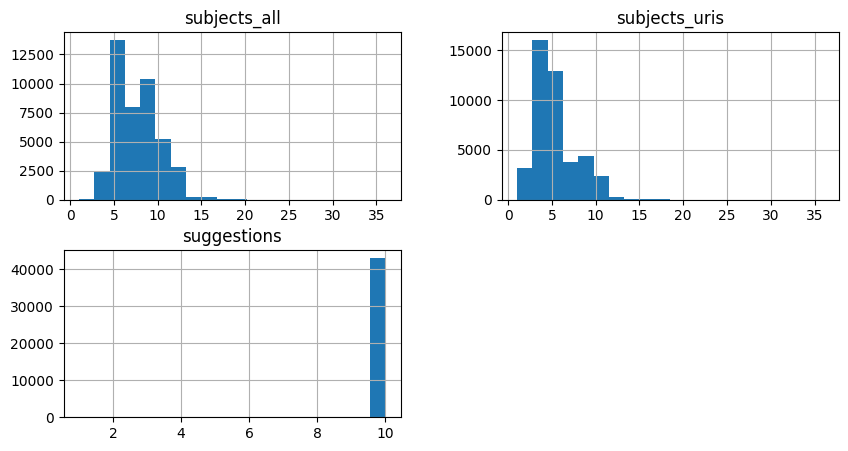

In [10]:
# How many subjects and suggestions?
df_fi[["subjects_all", "subjects_uris", "suggestions"]].applymap(lambda x: len(x)).hist(bins=20, figsize=(10, 5))
df_fi[["subjects_all", "subjects_uris", "suggestions"]].applymap(lambda x: len(x)).describe()

In [11]:
# How many subjects_uris not in suggestions? (Handpicked subjects)
df_fi.apply(lambda x: len(set(x.subjects_uris) - set(x.suggestions)), axis=1).describe()

count    43192.000000
mean         0.576611
std          1.165443
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         24.000000
dtype: float64

In [12]:
df_fi[["subjects_all", "subjects_uris", "suggestions"]].head()

,subjects_all,subjects_uris,suggestions
440,"[Tuotantopainoitteinen, fi=Rakennus- ja yhdysk...","[http://www.yso.fi/onto/yso/p4794, http://www....","[http://www.yso.fi/onto/yso/p4794, http://www...."
441,"[fi=Liiketalous, hallinto ja markkinointi|sv=F...","[http://www.yso.fi/onto/yso/p14072, http://www...","[http://www.yso.fi/onto/yso/p14072, http://www..."
452,[fi=Sosiaaliala|sv=Sociala området|en=Social S...,"[http://www.yso.fi/onto/yso/p3485, http://www....","[http://www.yso.fi/onto/yso/p3485, http://www...."
454,[fi=Fysioterapia|sv=Fysioterapi|en=Physiothera...,"[http://www.yso.fi/onto/yso/p3320, http://www....","[http://www.yso.fi/onto/yso/p2710, http://www...."
455,[fi=Energia- ja ympäristötekniikka|sv=Energi- ...,"[http://www.yso.fi/onto/yso/p20373, http://www...","[http://www.yso.fi/onto/yso/p20373, http://www..."


## Number of records with perfect and zero precision, recall, f1

In [13]:
# count of rows with precision, recall, f1 score == 0
print("All: ", len(df_fi))
print("precision == 0: ", len(df_fi[df_fi['precision'] == 0]))
print("recall == 0: ", len(df_fi[df_fi['recall'] == 0]))
print("f1 score == 0: ", len(df_fi[df_fi['f1 score'] == 0]))
print("precision == 1: ", len(df_fi[df_fi['precision'] == 1]))
print("recall == 1: ", len(df_fi[df_fi['recall'] == 1]))
print("f1 score == 1: ", len(df_fi[df_fi['f1 score'] == 1]))

All:  43192
precision == 0:  421
recall == 0:  421
f1 score == 0:  421
precision == 1:  1907
recall == 1:  29867
f1 score == 1:  1584


## Results per degree programme

In [14]:
df_fi.degreeprogram.unique()

array(['fi=Rakennus- ja yhdyskuntatekniikka|sv=Byggnads- och samhällsteknik|en=Civil and Construction Engineering|',
       'fi=Liiketalous, hallinto ja markkinointi|sv=Företagsekonomi, förvaltning och marknadsföring|en=Business Management, Administration and Marketing|',
       'fi=Sosiaaliala|sv=Sociala området|en=Social Sciences|',
       'fi=Fysioterapia|sv=Fysioterapi|en=Physiotherapy|',
       'fi=Energia- ja ympäristötekniikka|sv=Energi- och miljöteknik|en=Energy and Enviromental Engineering|',
       'fi=Teknologiaosaamisen johtaminen|sv=Teknologibaserat ledarskap|en=Technology Management|',
       'fi=Automaatiotekniikka|sv=Automationsteknik|en=Automation Engineering|',
       'fi=Rakennusmestarit|sv=Byggmästare|en=Construction Managers|', '',
       'fi=Tietojenkäsittely|sv=Informationsbehandling|en=Business Information Technology|',
       'fi=Luonnonvara- ja ympäristöala|sv=Bioekonomi och Miljöbranschen|en=Natural Resources and Environment|',
       'fi=Sosiaali- ja terveys

In [15]:
df_fi[df_fi.degreeprogram == ''].type.unique()

array(['publication',
       "fi=Publisher's version|sv=Publisher's version|en=Publisher's version|"],
      dtype=object)

In [16]:
# assign special value to empty degreeprogram
df_fi.loc[df_fi.degreeprogram == '', 'degreeprogram'] = '(Muu julkaisu)'

In [17]:
# mean precision, recall, f1 score for each degree program and sort by f1 score
df_per_dp = df_fi.groupby("degreeprogram")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).sort_values(by=('f1 score', 'mean'), ascending=False)
# rename degree program entries to take only the first part of the name
df_per_dp.index = df_per_dp.index.map(lambda x: x.split("|")[0].lstrip("fi="))

# copy to clipboard
df_per_dp[df_per_dp.precision['count'] > 400].to_clipboard()
df_per_dp[df_per_dp.precision['count'] > 400]

/tmp/ipykernel_311370/2085424453.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_per_dp = df_fi.groupby("degreeprogram")['precision', 'recall', 'f1 score'].agg(['mean', 'count']).sort_values(by=('f1 score', 'mean'), ascending=False)


precision          recall        \
                                           mean count      mean count   
degreeprogram                                                           
Esittävä taide ja musiikki             0.566667   564  0.857437   564   
(Muu julkaisu)                         0.573130   887  0.812999   887   
Liikunta-ala                           0.521739   414  0.906808   414   
Yhteisöpedagogiikka                    0.518868   636  0.866543   636   
Poliisi                                0.500965   622  0.917459   622   
Fysioterapia                           0.508449   793  0.879076   793   
Muotoilu                               0.514618   602  0.854029   602   
Terveydenhoitotyö                      0.500700  1064  0.895799  1064   
Hoitotyö                               0.485281  3509  0.899074  3509   
Majoitus- ja ravitsemisala             0.479258  1051  0.905636  1051   
Media-ala                              0.500501   798  0.832742   798   
Matkailu                               0.474156   681  0.898642   681   
Sosiaaliala                            0.480475  3878  0.884638  3878   
Sosiaali- ja terveysalan johtaminen    0.471452  1262  0.892466  1262   
Energia- ja ympäristötekniikka         0.466857   871  0.900091   871   
Luonnonvara- ja ympäristöala           0.465803  1003  0.889492  1003   
Teknologiaosaamisen johtaminen         0.461897   403  0.905923   403   
Liiketalous, hallinto ja markkinointi  0.454797  9118  0.908565  9118   
Rakennusmestarit                       0.447659   598  0.923668   598   
Rakennus- ja yhdyskuntatekniikka       0.445923  1841  0.909763  1841   
Sähkötekniikka                         0.432256   866  0.920023   866   
Konetekniikka                          0.427016  1497  0.910619  1497   
Automaatiotekniikka                    0.412635   554  0.891461   554   
Tietojenkäsittely                      0.399592  1744  0.863027  1744   
Tieto- ja viestintätekniikka           0.386776  1503  0.851266  1503   

                                       f1 score        
                                           mean count  
degreeprogram                                          
Esittävä taide ja musiikki             0.659676   564  
(Muu julkaisu)                         0.645584   887  
Liikunta-ala                           0.634520   414  
Yhteisöpedagogiikka                    0.624266   636  
Poliisi                                0.622143   622  
Fysioterapia                           0.621499   793  
Muotoilu                               0.616197   602  
Terveydenhoitotyö                      0.616050  1064  
Hoitotyö                               0.606602  3509  
Majoitus- ja ravitsemisala             0.603656  1051  
Media-ala                              0.599889   798  
Matkailu                               0.597952   681  
Sosiaaliala                            0.597846  3878  
Sosiaali- ja terveysalan johtaminen    0.592722  1262  
Energia- ja ympäristötekniikka         0.589832   871  
Luonnonvara- ja ympäristöala           0.586798  1003  
Teknologiaosaamisen johtaminen         0.583850   403  
Liiketalous, hallinto ja markkinointi  0.581078  9118  
Rakennusmestarit                       0.575514   598  
Rakennus- ja yhdyskuntatekniikka       0.572269  1841  
Sähkötekniikka                         0.563815   866  
Konetekniikka                          0.555976  1497  
Automaatiotekniikka                    0.541768   554  
Tietojenkäsittely                      0.523860  1744  
Tieto- ja viestintätekniikka           0.508174  1503

/tmp/ipykernel_311370/3833675204.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  plt.xticks(pd.np.arange(0.5, 0.75, 0.05))


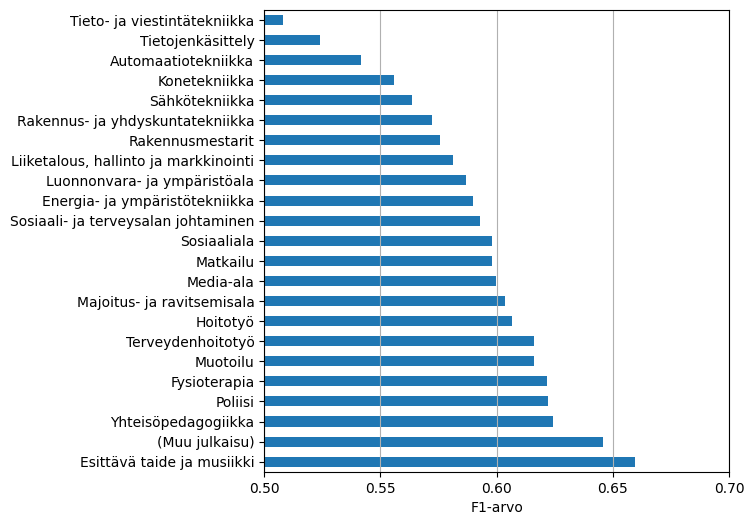

In [42]:
df_per_dp[df_per_dp.precision['count'] > 500]['f1 score']['mean'].plot.barh(figsize=(6, 6))
plt.ylabel(None)
plt.xlim(0.5, 0.7)
plt.xticks(pd.np.arange(0.5, 0.75, 0.05))
plt.xlabel("F1-arvo")
plt.grid(axis='x')